In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import copy
import warnings

import scipy
import scipy.integrate as integrate
from scipy import interpolate

import numpy as np 

from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table, Column, vstack

import matplotlib.pyplot as plt

In [2]:
import caterpillar

from caterpillar.filters import make_kfilter_file

In [3]:
filter_dir = '../../data/filters/merian'

In [4]:
decam_dir = '../../data/decam/'

In [5]:
decam_ccd = Table.read(os.path.join(decam_dir, 'decam_ccd_qe.txt'), format='ascii')

decam_m1 = Table.read(os.path.join(decam_dir, 'decam_m1_reflectance.txt'), format='ascii')

In [6]:
decam_ccd_intrp = interpolate.interp1d(decam_ccd['wavelength'], decam_ccd['QE'], kind='cubic')

decam_m1_intrp = interpolate.interp1d(decam_m1['wavelength'], decam_m1['reflectance'], kind='cubic')

## N708 Filter

- First get the transmission curves from Asahi. These are transmission curves tested in the factory using 49 different locations on the filter.
- CCD QE, Corrector transmission, and primary mirror transmission values are from Alistair Walker.

In [7]:
n708_asahi = np.loadtxt(os.path.join(filter_dir, 'merian_n708_asahi.txt'))

print(n708_asahi.shape)

(1001, 50)


(685.0, 735.0)

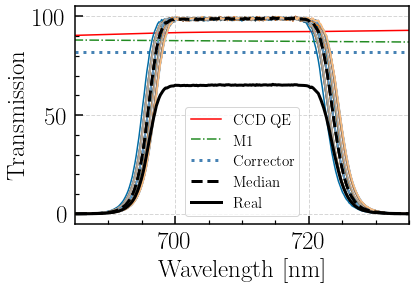

In [9]:
n708_fits = Table()

wave = n708_asahi[:, 0]
n708_fits['lambda'] = wave

curve_med = np.nanmedian(n708_asahi[:, 1:], axis=1)
curve_avg = np.nanmean(n708_asahi[:, 1:], axis=1)
n708_fits['med'] = curve_med / 100.
n708_fits['avg'] = curve_avg / 100.

for ii in np.arange(49):
    n708_fits["pos_{:d}".format(ii + 1)] = (n708_asahi[:, ii+1] / 100.)

n708_fits.write(os.path.join(filter_dir, 'merian_n708_asahi.fits'), overwrite=True)

plt.plot(wave, decam_ccd_intrp(wave) * 100., c='r', linestyle='-', label=r'$\rm CCD\ QE$')
plt.plot(wave, decam_m1_intrp(wave), c='forestgreen', linestyle='-.', label=r'$\rm M1$')
plt.axhline(82.0, c='steelblue', linestyle=':', linewidth=3, label=r'$\rm Corrector$')

for ii in np.arange(49):
    plt.plot(wave, n708_asahi[:, ii+1])
    
plt.plot(wave, (np.nanmedian(n708_asahi[:, 1:], axis=1)), linestyle='--', linewidth=3, c='k', label=r'$\rm Median$')

plt.plot(wave, (np.nanmedian(n708_asahi[:, 1:], axis=1)) * decam_ccd_intrp(wave) * (decam_m1_intrp(wave) / 100.0) * 0.82, linestyle='-', linewidth=3, c='k', label=r'$\rm Real$')

plt.legend(fontsize=15, loc='best')

plt.xlabel(r'$\rm Wavelength\ [nm]$', fontsize=25)
plt.ylabel(r'$\rm Transmission$', fontsize=25)

plt.xlim(685, 735)

In [10]:
decam_ccd_corr = decam_ccd_intrp(wave)
decam_m1_corr = decam_m1_intrp(wave)
decam_pfu_corr = 0.82 #Prime focus corrector

n708_corr = decam_ccd_corr * decam_m1_corr * decam_pfu_corr

In [86]:
n708_avg = os.path.join(filter_dir, 'merian_n708_avg.par')

make_kfilter_file(wave * 10.0, curve_avg * n708_corr / 100., par_name=n708_avg)

In [87]:
n708_med = os.path.join(filter_dir, 'merian_n708_med.par')

make_kfilter_file(wave * 10.0, curve_med * n708_corr / 100., par_name=n708_med)

In [88]:
for ii in np.arange(49):
    n708_par = os.path.join(filter_dir, 'n708', "merian_n708_{:d}.par".format(ii + 1))
    
    make_kfilter_file(wave * 10.0, n708_asahi[:, ii+1] * n708_corr / 100., par_name=n708_par)

In [53]:
np.argmax(n708_asahi[np.argwhere(wave == 695.)[0], 1:])

0

In [59]:
np.argmax(n708_asahi[np.argwhere(wave == 726.)[0], 1:])

47

Text(698, 50, '$\\Delta \\lambda \\sim 1.84\\ \\rm nm$')

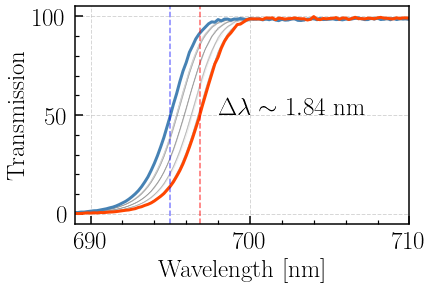

In [11]:
for ii in np.arange(49):
    plt.plot(wave, n708_asahi[:, ii+1], c='grey', alpha=0.2, linewidth=0.5)
    
plt.plot(wave, n708_asahi[:, 1], c='steelblue', linewidth=3)
plt.plot(wave, n708_asahi[:, 49], c='orangered', linewidth=3)
    
plt.xlabel(r'$\rm Wavelength\ [nm]$', fontsize=25)
plt.ylabel(r'$\rm Transmission$', fontsize=25)

mask = wave <= 700
plt.axvline(interpolate.interp1d(n708_asahi[:, 1][mask], wave[mask])(50.0), linestyle='--', c='blue', alpha=0.5)
plt.axvline(interpolate.interp1d(n708_asahi[:, 49][mask], wave[mask])(50.0), linestyle='--', c='red', alpha=0.6)

plt.xlim(689, 710)

plt.text(698, 50, r'$\Delta \lambda \sim 1.84\ \rm nm$', fontsize=25)

<ipython-input-18-7abe3f4a8a2c>:2: RuntimeWarning: divide by zero encountered in log10
  plt.plot(wave, np.log10(n708_asahi[:, ii+1]), c='grey', alpha=0.2, linewidth=0.5)
<ipython-input-18-7abe3f4a8a2c>:2: RuntimeWarning: divide by zero encountered in log10
  plt.plot(wave, np.log10(n708_asahi[:, ii+1]), c='grey', alpha=0.2, linewidth=0.5)
<ipython-input-18-7abe3f4a8a2c>:2: RuntimeWarning: divide by zero encountered in log10
  plt.plot(wave, np.log10(n708_asahi[:, ii+1]), c='grey', alpha=0.2, linewidth=0.5)
<ipython-input-18-7abe3f4a8a2c>:2: RuntimeWarning: divide by zero encountered in log10
  plt.plot(wave, np.log10(n708_asahi[:, ii+1]), c='grey', alpha=0.2, linewidth=0.5)
<ipython-input-18-7abe3f4a8a2c>:2: RuntimeWarning: divide by zero encountered in log10
  plt.plot(wave, np.log10(n708_asahi[:, ii+1]), c='grey', alpha=0.2, linewidth=0.5)
<ipython-input-18-7abe3f4a8a2c>:2: RuntimeWarning: divide by zero encountered in log10
  plt.plot(wave, np.log10(n708_asahi[:, ii+1]), c='grey', 

(672.0, 701.0)

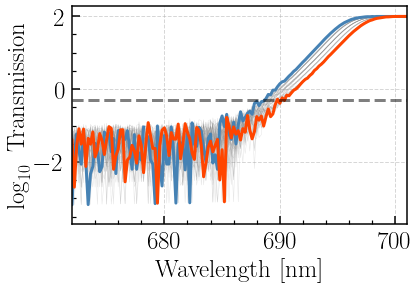

In [18]:
for ii in np.arange(49):
    plt.plot(wave, np.log10(n708_asahi[:, ii+1]), c='grey', alpha=0.2, linewidth=0.5)
    
plt.plot(wave, np.log10(n708_asahi[:, 1]), c='steelblue', linewidth=3)
plt.plot(wave, np.log10(n708_asahi[:, 49]), c='orangered', linewidth=3)
    
plt.xlabel(r'$\rm Wavelength\ [nm]$', fontsize=25)
plt.ylabel(r'$\log_{10}\ \rm Transmission$', fontsize=25)

plt.axhline(np.log10(0.5), linestyle='--', linewidth=3, c='k', alpha=0.5)

plt.xlim(672, 701)

In [82]:
interpolate.interp1d(n708_asahi[:, 1][mask], wave[mask])(50.0) - interpolate.interp1d(n708_asahi[:, 49][mask], wave[mask])(50.0)

-1.8395755981154025

## N540 Filter

- First get the transmission curves from Asahi. These are transmission curves tested in the factory using 49 different locations on the filter.
- CCD QE, Corrector transmission, and primary mirror transmission values are from Alistair Walker.

In [19]:
n540_asahi = np.loadtxt(os.path.join(filter_dir, 'merian_n540_asahi.txt'))

print(n540_asahi.shape)

(501, 50)


(515.0, 575.0)

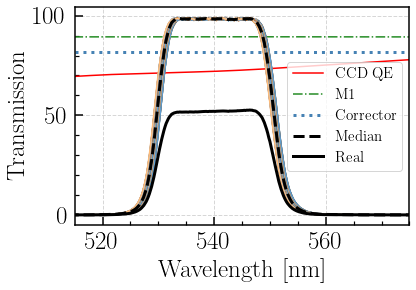

In [23]:
n540_fits = Table()

wave = n540_asahi[:, 0]
n540_fits['lambda'] = wave

curve_med = np.nanmedian(n540_asahi[:, 1:], axis=1)
curve_avg = np.nanmean(n540_asahi[:, 1:], axis=1)
n540_fits['med'] = curve_med / 100.
n540_fits['avg'] = curve_avg / 100.

for ii in np.arange(49):
    n540_fits["pos_{:d}".format(ii + 1)] = (n540_asahi[:, ii+1] / 100.)

n540_fits.write(os.path.join(filter_dir, 'merian_n540_asahi.fits'), overwrite=True)

plt.plot(wave, decam_ccd_intrp(wave) * 100., c='r', linestyle='-', label=r'$\rm CCD\ QE$')
plt.plot(wave, decam_m1_intrp(wave), c='forestgreen', linestyle='-.', label=r'$\rm M1$')
plt.axhline(82.0, c='steelblue', linestyle=':', linewidth=3, label=r'$\rm Corrector$')

for ii in np.arange(49):
    plt.plot(wave, n540_asahi[:, ii+1])
    
plt.plot(wave, (np.nanmedian(n540_asahi[:, 1:], axis=1)), linestyle='--', linewidth=3, c='k', label=r'$\rm Median$')

plt.plot(wave, (np.nanmedian(n540_asahi[:, 1:], axis=1)) * decam_ccd_intrp(wave) * (decam_m1_intrp(wave) / 100.0) * 0.82, linestyle='-', linewidth=3, c='k', label=r'$\rm Real$')

plt.legend(fontsize=15, loc='best')

plt.xlabel(r'$\rm Wavelength\ [nm]$', fontsize=25)
plt.ylabel(r'$\rm Transmission$', fontsize=25)

plt.xlim(515, 575)

In [24]:
decam_ccd_corr = decam_ccd_intrp(wave)
decam_m1_corr = decam_m1_intrp(wave)
decam_pfu_corr = 0.82 #Prime focus corrector

n540_corr = decam_ccd_corr * decam_m1_corr * decam_pfu_corr

In [25]:
n540_avg = os.path.join(filter_dir, 'merian_n540_avg.par')

make_kfilter_file(wave * 10.0, curve_avg * n540_corr / 100., par_name=n540_avg)

In [26]:
n540_med = os.path.join(filter_dir, 'merian_n540_med.par')

make_kfilter_file(wave * 10.0, curve_med * n540_corr / 100., par_name=n540_med)

In [27]:
for ii in np.arange(49):
    n540_par = os.path.join(filter_dir, 'n540', "merian_n540_{:d}.par".format(ii + 1))
    
    make_kfilter_file(wave * 10.0, n540_asahi[:, ii+1] * n540_corr / 100., par_name=n540_par)

1.1500153962134618


Text(522.5, 50, '$\\Delta \\lambda \\sim 1.15\\ \\rm nm$')

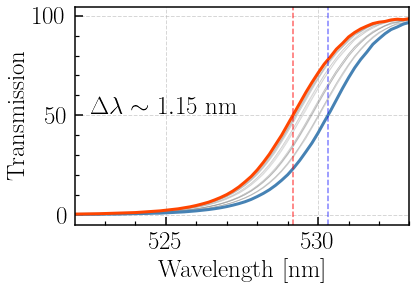

In [34]:
for ii in np.arange(49):
    plt.plot(wave, n540_asahi[:, ii+1], c='grey', alpha=0.2, linewidth=0.5)
    
plt.plot(wave, n540_asahi[:, 1], c='steelblue', linewidth=3)
plt.plot(wave, n540_asahi[:, 49], c='orangered', linewidth=3)
    
plt.xlabel(r'$\rm Wavelength\ [nm]$', fontsize=25)
plt.ylabel(r'$\rm Transmission$', fontsize=25)

mask = wave <= 540
print(interpolate.interp1d(n540_asahi[:, 1][mask], wave[mask])(50.0) - interpolate.interp1d(n540_asahi[:, 49][mask], wave[mask])(50.0))

plt.axvline(interpolate.interp1d(n540_asahi[:, 1][mask], wave[mask])(50.0), linestyle='--', c='blue', alpha=0.5)
plt.axvline(interpolate.interp1d(n540_asahi[:, 49][mask], wave[mask])(50.0), linestyle='--', c='red', alpha=0.6)

plt.xlim(522, 533)

plt.text(522.5, 50, r'$\Delta \lambda \sim 1.15\ \rm nm$', fontsize=25)

1.1069501610652424


Text(552.5, 50, '$\\Delta \\lambda \\sim 1.11\\ \\rm nm$')

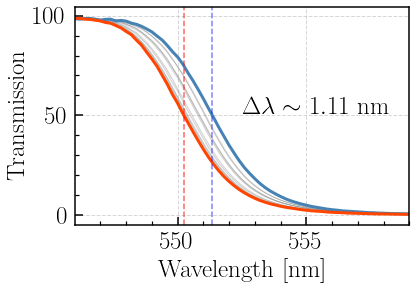

In [41]:
for ii in np.arange(49):
    plt.plot(wave, n540_asahi[:, ii+1], c='grey', alpha=0.2, linewidth=0.5)
    
plt.plot(wave, n540_asahi[:, 1], c='steelblue', linewidth=3)
plt.plot(wave, n540_asahi[:, 49], c='orangered', linewidth=3)
    
plt.xlabel(r'$\rm Wavelength\ [nm]$', fontsize=25)
plt.ylabel(r'$\rm Transmission$', fontsize=25)

mask = wave >= 550
print(interpolate.interp1d(n540_asahi[:, 1][mask], wave[mask])(50.0) - interpolate.interp1d(n540_asahi[:, 49][mask], wave[mask])(50.0))

plt.axvline(interpolate.interp1d(n540_asahi[:, 1][mask], wave[mask])(50.0), linestyle='--', c='blue', alpha=0.5)
plt.axvline(interpolate.interp1d(n540_asahi[:, 49][mask], wave[mask])(50.0), linestyle='--', c='red', alpha=0.6)

plt.xlim(546, 559)

plt.text(552.5, 50, r'$\Delta \lambda \sim 1.11\ \rm nm$', fontsize=25)